In [1]:
import torch

def synthetic_data(w, b, nums):
    """生成 y=Xw+b+噪声"""
    X = torch.normal(0, 1, (nums, len(w)))#行向量为每一个x
    y = torch.matmul(X, w) + b  # 矩阵相乘，注意shape要适合
    y += torch.normal(0, 0.01, y.shape)  # 统一加上随机噪声,误差限为0.01
    return X, y.reshape(-1, 1)#返回X和列向量形式的y,-1为自适应值


如果第一个参数或者第二个参数是1 维的，它会提升该参数为矩阵（根据另一个参数维数，给该参数增加一个为1的维数）。矩阵相乘之后会将为1的维数去掉。
<img src="https://img-blog.csdnimg.cn/20191024150304114.jpg?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3l1XzE2MjgwNjA3Mzk=,size_16,color_FFFFFF,t_70"/>

In [2]:
true_w=torch.tensor([2,-3.4])#乘积时会被提升为对应的[2x1]矩阵
print(true_w)
true_b=4.2
nums=1000
features,labels=synthetic_data(true_w,true_b,nums)#生成数据集和标签


tensor([ 2.0000, -3.4000])


features[0]: tensor([1.4182, 0.0120]) 
labels[0]: tensor([6.9870])


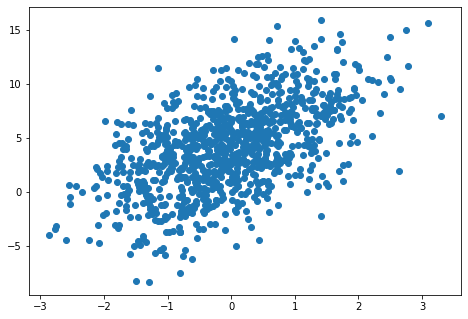

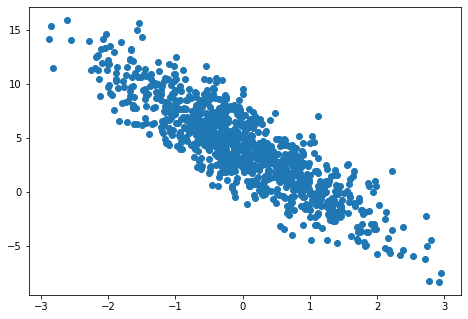

In [3]:
print('features[0]:',features[0],'\nlabels[0]:',labels[0])#X[0]和y[0]

from matplotlib import pyplot as plt

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(features[:,0].numpy(),labels.numpy())#取x序列的第0列作为横坐标
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(features[:,1].numpy(),labels.numpy())#取第1列

In [4]:
import random


def data_iter(batch_size, features, labels):  # 数据迭代器：每次运行返回随机的一段数据
    nums = len(features)
    indices = list(range(nums))  # 构造下标序列
    # 等价于 indices=[*range((nums))]
    random.shuffle(indices)  # 打乱序列
    for i in range(0, nums, batch_size):
        batch_indices = torch.tensor(
            indices[i : min(i + batch_size, nums)]
        )  # 拿出最大batch_size的一块
        yield features[batch_indices], labels[batch_indices]


batch_size = 10

for x, y in data_iter(batch_size, features, labels):
    print(x, "\n", y)
    break
    # 迭代一次即退出


tensor([[-0.5811, -1.4433],
        [ 0.4491, -0.9625],
        [ 1.1376, -1.6722],
        [ 1.8637,  0.9937],
        [ 0.5503,  0.4543],
        [-1.2444, -0.7640],
        [-0.1058,  0.2621],
        [ 0.5140, -1.8713],
        [-0.7531,  2.5285],
        [ 1.1240, -1.9165]]) 
 tensor([[ 7.9614],
        [ 8.3742],
        [12.1547],
        [ 4.5412],
        [ 3.7610],
        [ 4.3199],
        [ 3.0959],
        [11.5760],
        [-5.8856],
        [12.9488]])


In [5]:


def linreg(X,w,b):
    '''线性回归模型(linear regression)'''
    return torch.matmul(X,w)+b


In [10]:
def squared_loss(y_hat,y,batch_size):#结果仍为向量形式，没有求和
    '''一组数据的均方误差 y_hat:预测值，y:真实值'''
    return (y_hat-y)**2/(2*batch_size)


在使用pytorch时，并不是所有的操作都需要进行计算图的生成（计算过程的构建，以便梯度反向传播等操作）。而对于tensor的计算操作，默认是要进行计算图的构建的，在这种情况下，可以使用 with torch.no_grad():，强制之后的内容不进行计算图构建。

x本来是不能-=的，但是加上了with torch.no_grad，在计算时，认为x的requires_grad = False，因此可以进行-=，但是-=结束，新的x的requires_grad仍旧为True。

In [7]:
def sgd(params,lr):
    '''随机梯度下降(stochastic gradient descent),lr:学习率'''
    with torch.no_grad():#不生成计算图
        for param in params:
            param-=lr*param.grad
            param.grad.zero_()#清零便于下次计算



In [8]:
w = torch.normal(0, 0.01, (2, 1), requires_grad=True)
b = torch.tensor([0.0], requires_grad=True)

lr_list = [0.001, 0.01, 0.1, 1,10]
nums_epoch = 3  # 人工智慧训练型样数
net = linreg
loss = squared_loss
for lr in lr_list:
    print(f"learning rate为：{lr}时:")
    for epoch in range(nums_epoch):
        for X, y in data_iter(batch_size, features, labels):
            l = loss(net(X, w, b), y,batch_size)
            l.sum().backward()  # 求和计算梯度
            sgd([w, b], lr)  # 梯度下降，更新参数w和b
        with torch.no_grad():  # train_loss不会被加入计算图,用l代替train_loss也可以
            train_loss = loss(net(features, w, b), labels,batch_size)  # 运行过程中对整个数据集进行评估
            print(f"epoch {epoch+1},loss {float(train_loss.mean())}")
    print(f"w的估计误差：{true_w.reshape(w.shape)-w}")  # 将1D张量ture_w转为2x1矩阵再计算
    print(f"b的估计误差：{true_b-b}")


learning rate为：0.001时:
epoch 1,loss 1.3568943738937378
epoch 2,loss 1.1114373207092285
epoch 3,loss 0.9104033708572388
w的估计误差：tensor([[ 1.4717],
        [-2.5081]], grad_fn=<SubBackward0>)
b的估计误差：tensor([3.1334], grad_fn=<RsubBackward1>)
learning rate为：0.01时:
epoch 1,loss 0.12252426892518997
epoch 2,loss 0.016516894102096558
epoch 3,loss 0.0022392277605831623
w的估计误差：tensor([[ 0.0644],
        [-0.1179]], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.1641], grad_fn=<RsubBackward1>)
learning rate为：0.1时:
epoch 1,loss 5.041521035309415e-06
epoch 2,loss 4.895809070148971e-06
epoch 3,loss 4.91860055262805e-06
w的估计误差：tensor([[0.0001],
        [0.0009]], grad_fn=<SubBackward0>)
b的估计误差：tensor([-7.5340e-05], grad_fn=<RsubBackward1>)
learning rate为：1时:
epoch 1,loss 5.720142326026689e-06
epoch 2,loss 5.215409146330785e-06
epoch 3,loss 5.515149950952036e-06
w的估计误差：tensor([[-3.1166e-03],
        [ 8.6308e-05]], grad_fn=<SubBackward0>)
b的估计误差：tensor([-0.0010], grad_fn=<RsubBackward1>)
learning rate为：10时:
